# Transfer Learning

In [1]:
import os
import cv2
import json
import numpy as np
import mediapipe as mp
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [ ]:
hands = mp.solutions.hands.Hands()
                
def get_hands_landmarks(frame):
    results = hands.process(frame)
    landmarks = np.zeros((42, 3))
    if results.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
            if results.multi_handedness[i].classification[0].index == 0: 
                landmarks[:21, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
            else:
                landmarks[21:, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left
    return landmarks

In [ ]:
def collect_images(dataset_path):
    cap = cv2.VideoCapture(0)
    print("Press c to capture image and q to quit")
    label = input("Enter label name: ")
    os.makedirs(f'{dataset_path}/{label}', exist_ok=True)
    while True:
        ret, frame = cap.read()
        cv2.imshow('Adding Gesture', frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            filename = f'{dataset_path}/{label}/{len(os.listdir(f"{dataset_path}/{label}"))}.jpg'
            cv2.imwrite(filename, frame)
            print(f"Image captured: {filename}")
        elif key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return label
    
new_label = collect_images('dataset')

Press c to capture image and q to quit
Image captured: ../Dataset/test/0.jpg
Image captured: ../Dataset/test/1.jpg
Image captured: ../Dataset/test/2.jpg
Image captured: ../Dataset/test/3.jpg
Image captured: ../Dataset/test/4.jpg
Image captured: ../Dataset/test/5.jpg
Image captured: ../Dataset/test/6.jpg
Image captured: ../Dataset/test/7.jpg
Image captured: ../Dataset/test/8.jpg
Image captured: ../Dataset/test/9.jpg
Image captured: ../Dataset/test/10.jpg
Image captured: ../Dataset/test/11.jpg
Image captured: ../Dataset/test/12.jpg
Image captured: ../Dataset/test/13.jpg
Image captured: ../Dataset/test/14.jpg
Image captured: ../Dataset/test/15.jpg
Image captured: ../Dataset/test/16.jpg


In [ ]:
# def encode_data(dataset_path, output_path):
#     dataset = []
#     labels = []
#     os.makedirs(output_path, exist_ok=True)
#     mapping_path = os.path.join(output_path, 'label_mapping.json')

#     if os.path.exists(mapping_path):
#         with open(mapping_path, 'r') as f:
#             label_mapping = json.load(f)
#     else:
#         label_mapping = {}
        
#     for label in os.listdir(dataset_path):
#         if label not in label_mapping:
#             label_mapping[label] = len(label_mapping)
            
#     with open(mapping_path, 'w') as f:
#         json.dump(label_mapping, f)
        
#     for label in os.listdir(dataset_path):
#         for filename in os.listdir(os.path.join(dataset_path, label)):
#             frame = cv2.imread(os.path.join(dataset_path, label, filename))
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             landmarks = get_hands_landmarks(frame)
#             if np.all(landmarks == 0):
#                 continue
#             dataset.append(landmarks)
#             labels.append(label_mapping[label])
            
#     dataset = np.array(dataset)
#     labels = np.array(labels)
#     np.save(os.path.join(output_path, 'dataset.npy'), dataset)
#     np.save(os.path.join(output_path, 'labels.npy'), labels)
    
# encode_data('../Dataset', '../Encoded Data')

In [ ]:
def encode_new_only(dataset_path, output_path, new_label):
    dataset = np.load(os.path.join(output_path, 'dataset.npy'))
    labels = np.load(os.path.join(output_path, 'labels.npy'))
    mapping_path = os.path.join(output_path, 'label_mapping.json')
    
    with open(mapping_path, 'r') as f:
        label_mapping = json.load(f)
        
    if new_label not in label_mapping:
        label_mapping[new_label] = len(label_mapping)
        
    with open(mapping_path, 'w') as f:
        json.dump(label_mapping, f)
        
    new_dataset = []
    new_labels = []
    for filename in os.listdir(os.path.join(dataset_path, new_label)):
        frame = cv2.imread(os.path.join(dataset_path, new_label, filename))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        landmarks = get_hands_landmarks(frame)
        if np.all(landmarks == 0):
            continue
        new_dataset.append(landmarks)
        new_labels.append(label_mapping[new_label])
        
    new_dataset = np.array(new_dataset)
    new_labels = np.array(new_labels)
    dataset = np.concatenate((dataset, new_dataset))
    labels = np.concatenate((labels, new_labels))
    np.save(os.path.join(output_path, 'dataset.npy'), dataset)
    np.save(os.path.join(output_path, 'labels.npy'), labels)
    
encode_new_only('../Dataset', '../Encoded Data', new_label)

In [ ]:
def load_data(data_path):
    dataset = np.load(os.path.join(data_path, 'dataset.npy'))
    labels = np.load(os.path.join(data_path, 'labels.npy'))
    label_mapping = json.load(open(os.path.join(data_path, 'label_mapping.json'), 'r'))
    return dataset, labels, label_mapping

X, y, label_mapping = load_data('../Encoded Data')
num_classes = len(label_mapping)
print(X.shape, y.shape, num_classes)

(367, 42, 3) (367,) 9


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(293, 42, 3) (293,) (74, 42, 3) (74,)


In [ ]:
base_model = tf.keras.models.load_model('../Models/base.keras')

print("Training only the classification layer\n")
base_model.trainable = False
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(42, 3)),
    base_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])

print("\n\nFine-tuning the model\n")
base_model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[early_stopping])

history = {}
for key in history1.history:
    history[key] = history1.history[key] + history2.history[key]

Training only the classification layer

Epoch 1/100
10/10 [==============================] - 1s 41ms/step - loss: 4.3911 - accuracy: 0.0648 - val_loss: 3.3833 - val_accuracy: 0.1216
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 3.4251 - accuracy: 0.0819 - val_loss: 2.8164 - val_accuracy: 0.1622
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 2.8262 - accuracy: 0.0990 - val_loss: 2.4821 - val_accuracy: 0.2162
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 2.4405 - accuracy: 0.1399 - val_loss: 2.2111 - val_accuracy: 0.2162
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 2.1390 - accuracy: 0.2253 - val_loss: 2.0203 - val_accuracy: 0.3108
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 1.9204 - accuracy: 0.3413 - val_loss: 1.8977 - val_accuracy: 0.3378
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 1.7477 - accuracy: 0.3857 - val_los

In [ ]:
model.evaluate(X_train, y_train)

10/10 [==============================] - 0s 4ms/step - loss: 0.4899 - accuracy: 0.8362


[0.48987171053886414, 0.8361774682998657]

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 1.0011 - accuracy: 0.6892


[1.0010868310928345, 0.6891891956329346]

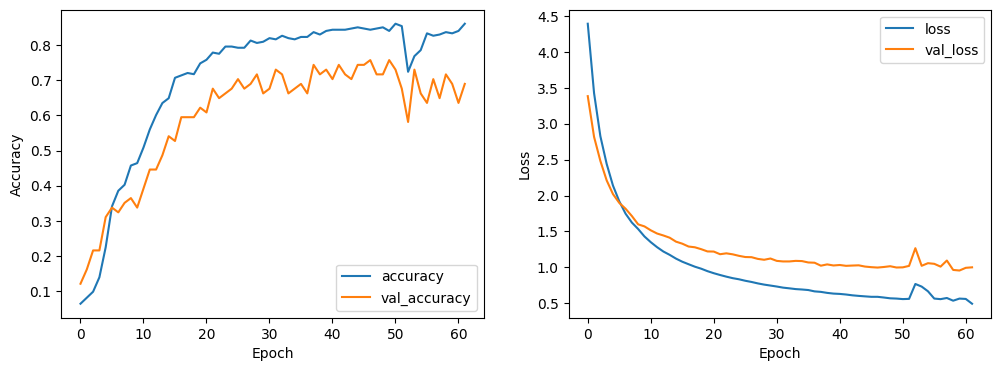

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
os.makedirs('../Models', exist_ok=True)
model.save('../Models/model.keras')
base_model.save('../Models/base.keras')

---

# Removing a gesture from the dataset

In [ ]:
def remove_gesture(output_path, label):
    dataset = np.load(os.path.join(output_path, 'dataset.npy'))
    labels = np.load(os.path.join(output_path, 'labels.npy'))
    mapping_path = os.path.join(output_path, 'label_mapping.json')
    
    with open(mapping_path, 'r') as f:
        label_mapping = json.load(f)
        
    if label in label_mapping:
        label_index = label_mapping[label]
        mask = labels != label_index
        dataset = dataset[mask]
        labels = labels[mask]
        label_mapping.pop(label)
        
        new_label_mapping = {}
        for i, l in enumerate(label_mapping):
            new_label_mapping[l] = i
        
        with open(mapping_path, 'w') as f:
            json.dump(new_label_mapping, f)
            
        np.save(os.path.join(output_path, 'dataset.npy'), dataset)
        np.save(os.path.join(output_path, 'labels.npy'), labels)
        
remove_gesture('../Encoded Data', 'hello')